# Gaussian processes

## Gaussian processes

Gaussian processes are distributions over functions $f(x)$:

$$f(x) \sim \mathcal{GP}(m(x),k(x,x'))$$

For any finite subset $X =\{\mathbf{x}_1 \ldots \mathbf{x}_n \}$ of the domain of $x$, the marginal distribution:

$$f(X) \sim \mathcal{N}(m(X), k(X, X))$$

with mean vector $\mathbf{\mu} = m(X)$ and covariance matrix $\Sigma = k(X, X)$.

## Gaussian processes for regression

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} + \sigma_\epsilon^2I & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right)
$$

Where:
$$\begin{split}
\mu_{1} & = m(X_1) \quad (n_1 \times 1) \\
\mu_{2} & = m(X_2) \quad (n_2 \times 1) \\
\Sigma_{11} & = k(X_1,X_1) \quad (n_1 \times n_1) \\
\Sigma_{22} & = k(X_2,X_2) \quad (n_2 \times n_2) \\
\Sigma_{12} & = k(X_1,X_2) = k_{21}^\top \quad (n_1 \times n_2)
\end{split}$$

Note that $\Sigma_{11}$ is independent of $\Sigma_{22}$ and vice versa.

$$\begin{split}
p(\mathbf{y}_2 \mid \mathbf{y}_1, X_1, X_2) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{y}_1 - \mu_1) \\
          & = \Sigma_{21} \Sigma_{11}^{-1} \mathbf{y}_1 \quad (\text{if assume mean prior }  \mu = 0 ) \\
          & = (\Sigma_{11}^{-1} \Sigma_{12})^{\top}  \mathbf{y}_1\\          
\Sigma_{2|1} & = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12} \\
& = \Sigma_{22} - (\Sigma_{11}^{-1} \Sigma_{12})^{\top} \Sigma_{12}
\end{split}$$

It is then possible to predict $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. 
Notice that the mean of the posterior predictions $\mu_{2|1}$ of a Gaussian process are weighted averages of the observed variables $\mathbf{y}_1$, where the weighting is based on the covariance function $k$. The variance $\sigma_2^2$ of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

In [22]:
# Imports
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib.pyplot as plt
np.random.seed(42)

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

# Gaussian process posterior with noisy obeservations
def GP(X1, y1, X2, kernel_func, noise):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the noisy observations 
    (y1, X1), and the prior kernel function.
    """
    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

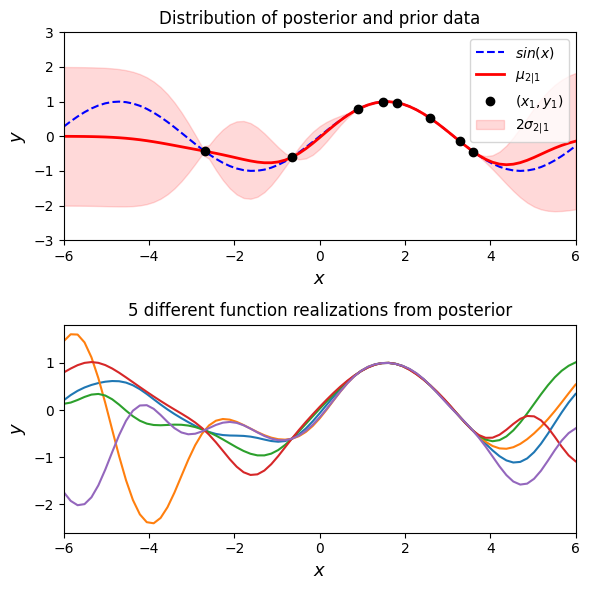

In [25]:
# Define the true function that we want to regress on
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 8   # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5   # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1,1))
noise = 0.  # The standard deviation of the noise
y1 = f_sin(X1) + (noise ** 2) * np.random.randn(n1)

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6,6), dpi=100)
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()

# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()